# Updated KGAT Model with Training, Validation, and Testing
This notebook implements the KGAT model with training, validation, and testing datasets, and plots the loss curves for both training and validation sets.

## Data Loading and Preprocessing

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the knowledge graph CSV
kg_df = pd.read_csv('knowledge_graph_movies.csv')

# Ensure the 'head', 'relation', and 'tail' columns are of categorical type
kg_df['head'] = kg_df['head'].astype('category')
kg_df['relation'] = kg_df['relation'].astype('category')
kg_df['tail'] = kg_df['tail'].astype('category')

# Convert entities and relations to categorical codes
head_codes = kg_df['head'].cat.codes
relation_codes = kg_df['relation'].cat.codes
tail_codes = kg_df['tail'].cat.codes

# Extract relevant tensors for KGAT
heads = torch.tensor(head_codes.values, dtype=torch.long)
relations = torch.tensor(relation_codes.values, dtype=torch.long)
tails = torch.tensor(tail_codes.values, dtype=torch.long)

# Split the data into training, validation, and testing datasets
heads_train, heads_temp, relations_train, relations_temp, tails_train, tails_temp = train_test_split(
    heads, relations, tails, test_size=0.4, random_state=42)

heads_val, heads_test, relations_val, relations_test, tails_val, tails_test = train_test_split(
    heads_temp, relations_temp, tails_temp, test_size=0.5, random_state=42)

# Check the size of each split
print(f"Training size: {len(heads_train)}, Validation size: {len(heads_val)}, Testing size: {len(heads_test)}")

Training size: 61735, Validation size: 20579, Testing size: 20579


In [2]:
def percentage_of_ones(tensor):
    # Count the number of 1s
    num_ones = torch.sum(tensor == 1).item()
    
    # Calculate the total number of elements
    total_elements = tensor.numel()
    
    # Calculate the percentage of 1s
    percentage = (num_ones / total_elements) * 100
    
    return percentage

# Example usage
percentage = percentage_of_ones(relations_test)
print(f"Percentage of 1s: {percentage:.2f}%")

Percentage of 1s: 97.24%


In [3]:
def create_batches(heads, relations, tails, batch_size):
    num_batches = len(heads) // batch_size
    for i in range(num_batches):
        yield (heads[i * batch_size:(i + 1) * batch_size],
               relations[i * batch_size:(i + 1) * batch_size],
               tails[i * batch_size:(i + 1) * batch_size])
    
    if len(heads) % batch_size != 0:
        yield (heads[num_batches * batch_size:],
               relations[num_batches * batch_size:],
               tails[num_batches * batch_size:])

## Simplified KGAT Model

In [4]:
import torch.nn as nn

class SimplifiedKGAT(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(SimplifiedKGAT, self).__init__()
        self.entity_embedding = nn.Embedding(num_entities, embedding_dim)
        self.relation_embedding = nn.Embedding(num_relations, embedding_dim)
        self.linear = nn.Linear(embedding_dim, embedding_dim)  # Simplified linear layer
        self.attention = nn.Linear(embedding_dim * 2, 1)  # Attention mechanism

    def forward(self, heads, relations, tails, negative_tails=None):
        head_emb = self.entity_embedding(heads)
        relation_emb = self.relation_embedding(relations)
        tail_emb = self.entity_embedding(tails)
        
        # Compute scores for positive samples
        pos_score = self.calculate_score(head_emb, relation_emb, tail_emb)

        if negative_tails is not None:
            negative_tail_emb = self.entity_embedding(negative_tails)
            # Compute scores for negative samples
            neg_score = self.calculate_score(head_emb, relation_emb, negative_tail_emb)
            return pos_score, neg_score

        return pos_score

    def calculate_score(self, head_emb, relation_emb, tail_emb):
        # Concatenate head and relation embeddings
        combined = torch.cat([head_emb, relation_emb], dim=-1)
        
        # Attention mechanism: Compute attention weights
        attention_weights = torch.sigmoid(self.attention(combined))
        
        # Apply attention to head and relation embeddings
        x = attention_weights * head_emb + (1 - attention_weights) * relation_emb
        
        # Pass through linear layer and activation
        x = self.linear(x)
        x = torch.relu(x)
        
        # Compute the score with the tail embedding
        score = torch.sum(x * tail_emb, dim=-1)  # Dot product as a score
        return score


#### Integerate MarginRankingLoss

In [107]:
import torch.nn.functional as F

class MarginRankingLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(MarginRankingLoss, self).__init__()
        self.margin = margin

    def forward(self, pos_score, neg_score):
        # Margin-based ranking loss
        loss = F.relu(self.margin - pos_score + neg_score).mean()
        return loss

## Model Training with Validation

In [112]:
# Instantiate the simplified model
embedding_dim = 8  # Adjust as necessary
num_entities = len(kg_df['head'].cat.categories) + len(kg_df['tail'].cat.categories)
num_relations = len(kg_df['relation'].cat.categories)
kgat_model = SimplifiedKGAT(num_entities, num_relations, embedding_dim)

def train_kgat_with_validation(model, heads_train, relations_train, tails_train, 
                               heads_val, relations_val, tails_val, 
                               epochs=10, batch_size=512, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    train_loss_values = []
    val_loss_values = []

    for epoch in range(epochs):
        model.train()
        train_batch_losses = []
        for batch_heads, batch_relations, batch_tails in create_batches(heads_train, relations_train, tails_train, batch_size):
            optimizer.zero_grad()

            # Forward pass
            out = model(batch_heads, batch_relations, batch_tails)

            # Ensure out is at least 2D
            if out.dim() == 1:
                out = out.unsqueeze(-1)

            # Compute loss with dummy labels
            labels = torch.ones_like(out)
            loss = criterion(out, labels)

            loss.backward()
            optimizer.step()

            train_batch_losses.append(loss.item())

        # Store the average loss for this epoch
        avg_train_loss = sum(train_batch_losses) / len(train_batch_losses)
        train_loss_values.append(avg_train_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_batch_losses = []
            for batch_heads, batch_relations, batch_tails in create_batches(heads_val, relations_val, tails_val, batch_size):
                out = model(batch_heads, batch_relations, batch_tails)
                
                # Ensure out is at least 2D
                if out.dim() == 1:
                    out = out.unsqueeze(-1)
                
                labels = torch.ones_like(out)
                loss = criterion(out, labels)
                val_batch_losses.append(loss.item())

        avg_val_loss = sum(val_batch_losses) / len(val_batch_losses)
        val_loss_values.append(avg_val_loss)

        if (epoch + 1) % 1 == 0:
            print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_loss_values, val_loss_values

# Train the model with training and validation loss tracking
train_loss_values, val_loss_values = train_kgat_with_validation(
    kgat_model, heads_train, relations_train, tails_train,
    heads_val, relations_val, tails_val, epochs=20, batch_size=256)

Epoch 1, Train Loss: 0.6950, Val Loss: 0.6838
Epoch 2, Train Loss: 0.6681, Val Loss: 0.6458
Epoch 3, Train Loss: 0.6005, Val Loss: 0.5485
Epoch 4, Train Loss: 0.4891, Val Loss: 0.4333
Epoch 5, Train Loss: 0.3798, Val Loss: 0.3348
Epoch 6, Train Loss: 0.2919, Val Loss: 0.2585
Epoch 7, Train Loss: 0.2248, Val Loss: 0.2006
Epoch 8, Train Loss: 0.1741, Val Loss: 0.1568
Epoch 9, Train Loss: 0.1362, Val Loss: 0.1244
Epoch 10, Train Loss: 0.1086, Val Loss: 0.1007
Epoch 11, Train Loss: 0.0885, Val Loss: 0.0835
Epoch 12, Train Loss: 0.0736, Val Loss: 0.0706
Epoch 13, Train Loss: 0.0623, Val Loss: 0.0607
Epoch 14, Train Loss: 0.0534, Val Loss: 0.0529
Epoch 15, Train Loss: 0.0462, Val Loss: 0.0466
Epoch 16, Train Loss: 0.0402, Val Loss: 0.0414
Epoch 17, Train Loss: 0.0352, Val Loss: 0.0371
Epoch 18, Train Loss: 0.0310, Val Loss: 0.0335
Epoch 19, Train Loss: 0.0274, Val Loss: 0.0304
Epoch 20, Train Loss: 0.0243, Val Loss: 0.0277


In [113]:
def plot_loss_curve(train_loss_values, val_loss_values):
    # Plot the training and validation loss curves
    plt.plot(train_loss_values, label='Training Loss')
    plt.plot(val_loss_values, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.show()

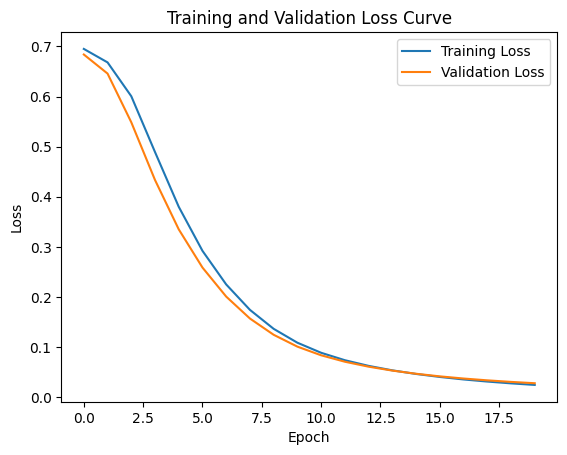

In [114]:
# Plot the loss curves
plot_loss_curve(train_loss_values, val_loss_values)

In [18]:
def predict(model, heads, relations, tails, k=10):
    model.eval()
    with torch.no_grad():
        num_entities = model.entity_embedding.num_embeddings
        all_tails = torch.arange(num_entities, device=heads.device)
        
        scores = []
        for head, relation in zip(heads, relations):
            head = head.unsqueeze(0).repeat(num_entities)
            relation = relation.unsqueeze(0).repeat(num_entities)
            score = model(head, relation, all_tails)
            scores.append(score)
        
        scores = torch.stack(scores, dim=0)
        _, top_k_indices = torch.topk(scores, k, dim=1)
        
    return scores, top_k_indices

In [36]:
import numpy as np

In [37]:
def evaluate(model, heads, relations, tails, k=10):
    model.eval()
    hr, ndcg = [], []

    with torch.no_grad():
        scores, top_k_indices = predict(model, heads, relations, tails, k)
        
        for i in range(len(heads)):
            tail = tails[i]
            top_k = top_k_indices[i]
            
            if tail in top_k:
                hr.append(1)
                rank_indices = (top_k == tail).nonzero(as_tuple=True)[0]
                if len(rank_indices) > 0:  # Check if there is at least one match
                    rank = rank_indices[0].item()  # Take the first occurrence
                    ndcg.append(1.0 / np.log2(rank + 2))
                else:
                    ndcg.append(0)
            else:
                hr.append(0)
                ndcg.append(0)
    
    mean_hr = np.mean(hr)
    mean_ndcg = np.mean(ndcg)
    
    return mean_hr, mean_ndcg


In [44]:
def custom_inspect_predictions(model, heads, relations, tails, k=10):
    scores, top_k_indices = predict(model, heads, relations, tails, k)
    
    for i in range(min(5, len(heads))):  # Inspect the first 5 samples
        print(f"User {i+1}:")
        print(f"  Actual Item: {tails[i].item()}")
        print(f"  Top-{k} Predictions: {top_k_indices[i].cpu().numpy().tolist()}")
        print(f"  Scores: {scores[i][top_k_indices[i]].cpu().numpy().tolist()}")
        print("-" * 50)


In [19]:
scores, top_k_predictions = predict(kgat_model, heads_test, relations_test, tails_test, k=10)

In [65]:
k = 20

mean_hr, mean_ndcg = evaluate(kgat_model, heads_test, relations_test, tails_test, k)
print(f"Mean HR@{k}: {mean_hr}")
print(f"Mean NDCG@{k}: {mean_ndcg}")

Mean HR@20: 0.10345497837601439
Mean NDCG@20: 0.04051105562687961


In [56]:
custom_inspect_predictions(kgat_model, heads_test, relations_test, tails_test, k)

User 1:
  Actual Item: 1
  Top-10 Predictions: [540, 4, 7, 1133, 759, 1, 0, 63, 5, 3]
  Scores: [9.601744651794434, 9.422332763671875, 8.773859024047852, 8.713765144348145, 8.687373161315918, 8.67309284210205, 8.191333770751953, 8.11245346069336, 8.10355281829834, 7.964412689208984]
--------------------------------------------------
User 2:
  Actual Item: 804
  Top-10 Predictions: [1146, 908, 917, 877, 910, 1367, 897, 253, 1678, 807]
  Scores: [3.51345157623291, 3.431138038635254, 3.4048678874969482, 3.3303723335266113, 3.3254547119140625, 3.3151674270629883, 3.2851593494415283, 3.276028633117676, 3.267214298248291, 3.2601921558380127]
--------------------------------------------------
User 3:
  Actual Item: 948
  Top-10 Predictions: [1146, 908, 877, 910, 917, 1367, 1678, 20, 319, 253]
  Scores: [2.970454216003418, 2.9085988998413086, 2.881974458694458, 2.8283464908599854, 2.824836254119873, 2.799471855163574, 2.7947168350219727, 2.765075445175171, 2.7630057334899902, 2.748376846313476

In [72]:
# Assuming you have already defined the following:
# heads_train, relations_train, tails_train -> Training dataset
# heads_val, relations_val, tails_val -> Validation dataset
# k -> The value of k used for evaluation

# Evaluate on the Training Dataset
train_hr, train_ndcg = evaluate(kgat_model, heads_train, relations_train, tails_train, k=k)
print(f"Training HR@{k}: {train_hr:.4f}")
print(f"Training NDCG@{k}: {train_ndcg:.4f}")

Training HR@20: 0.1046
Training NDCG@20: 0.0416


In [67]:
custom_inspect_predictions(kgat_model, heads_train, relations_train, tails_train, k)

User 1:
  Actual Item: 1033
  Top-20 Predictions: [1146, 908, 877, 910, 917, 1367, 1678, 20, 319, 253, 792, 1212, 838, 18, 1467, 807, 782, 784, 1578, 897]
  Scores: [3.6349291801452637, 3.550260543823242, 3.5220212936401367, 3.4643359184265137, 3.458406448364258, 3.4355931282043457, 3.416128158569336, 3.386686086654663, 3.383267879486084, 3.3628807067871094, 3.3624935150146484, 3.335587501525879, 3.3068008422851562, 3.301109790802002, 3.3010854721069336, 3.300210952758789, 3.2917699813842773, 3.2904887199401855, 3.2839088439941406, 3.272402286529541]
--------------------------------------------------
User 2:
  Actual Item: 818
  Top-20 Predictions: [1146, 917, 1367, 908, 910, 792, 897, 253, 1467, 319, 877, 1212, 20, 782, 825, 1678, 807, 1061, 1041, 925]
  Scores: [3.2089293003082275, 3.146122932434082, 3.10410737991333, 3.0624663829803467, 3.0547683238983154, 3.0137033462524414, 3.01314115524292, 2.9992856979370117, 2.9933953285217285, 2.989582061767578, 2.9774134159088135, 2.975503921

## Conclusion
This notebook combines the key steps of data loading, model training, validation, and evaluation for the KGAT model.